In [1]:
!pip install yfinance
import numpy as np
import pandas as pd
import warnings
import os
import yfinance as yf
import matplotlib.pylab as plt

     |████████████████████████████████| 6.4 MB 18.9 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
#1년

In [3]:
df = yf.download('^KS11', start = '2019-01-01', end='2019-12-31')
#^KS11 : KOSPI Composite Index (코스피 지수)
#^KQ11 : KOSDAQ Composite Index (코스닥 지수)
#KOSPI 200 Index (^KS200)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,2050.550049,2053.449951,2004.270020,2010.000000,2010.000000,326400
2019-01-03,2011.810059,2014.719971,1991.650024,1993.699951,1993.699951,428000
2019-01-04,1992.400024,2011.560059,1984.530029,2010.250000,2010.250000,409000
2019-01-07,2034.239990,2048.060059,2030.900024,2037.099976,2037.099976,440200
2019-01-08,2038.680054,2042.699951,2023.589966,2025.270020,2025.270020,397800


In [5]:
df['CODE'] = 'SPY'
price_df = df.loc[:,['Adj Close']].copy()
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선
  # +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 
  # -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

n = 20 #이평선
sigma = 2 #시그마

def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선 
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

bollinger = bollinger_band(price_df, n, sigma)

base_date = '2009-01-02'

sample = bollinger.loc[base_date:]
book = sample[['Adj Close']].copy()
book['trade'] = '' #거래내역 컬럼

def create_trade_book(sample):
  book = sample[['Adj Close']].copy()
  book['trade'] = ''
  return (book)   

book = create_trade_book(sample)

def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
               book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

book = tradings(sample,book)

for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
           buy = book.loc[i, 'Adj Close']
           print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

print(returns(book))    

진입일 :  2019-03-08 00:00:00 long 진입가격 :  2137.43994140625
청산일 :  2019-04-03 00:00:00 long 진입가격 :  2137.43994140625  |  long 청산가격 :  2203.27001953125  | return: 1.0308
진입일 :  2019-05-09 00:00:00 long 진입가격 :  2102.010009765625
청산일 :  2019-06-10 00:00:00 long 진입가격 :  2102.010009765625  |  long 청산가격 :  2099.489990234375  | return: 0.9988
진입일 :  2019-07-08 00:00:00 long 진입가격 :  2064.169921875
청산일 :  2019-09-04 00:00:00 long 진입가격 :  2064.169921875  |  long 청산가격 :  1988.530029296875  | return: 0.9634
진입일 :  2019-11-29 00:00:00 long 진입가격 :  2087.9599609375
청산일 :  2019-12-13 00:00:00 long 진입가격 :  2087.9599609375  |  long 청산가격 :  2170.25  | return: 1.0394
진입일 :  2019-03-08 00:00:00 long 진입가격 :  2137.43994140625
청산일 :  2019-04-03 00:00:00 long 진입가격 :  2137.43994140625  |  long 청산가격 :  2203.27001953125  | return: 1.0308
진입일 :  2019-05-09 00:00:00 long 진입가격 :  2102.010009765625
청산일 :  2019-06-10 00:00:00 long 진입가격 :  2102.010009765625  |  long 청산가격 :  2099.489990234375  | return: 0.9988
진입일 :  2019-

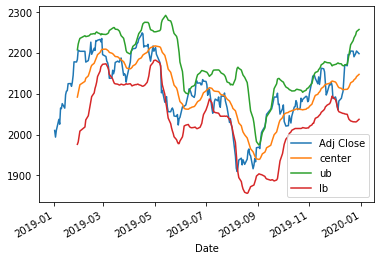

In [6]:
sample[['Adj Close',	'center',	'ub',	'lb']].plot()

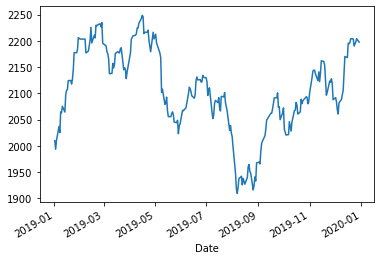

In [7]:
df['Adj Close'].plot() #수정종가

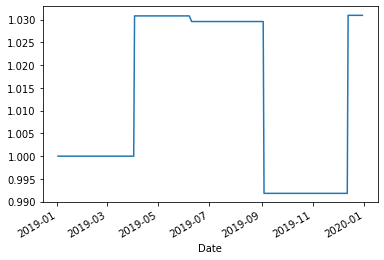

In [8]:
book['acc return'].plot() #누적수익률

In [9]:
#3년

In [10]:
df = yf.download('^KS11', start = '2017-01-01', end='2019-12-31')
#^KS11 : KOSPI Composite Index (코스피 지수)
#^KQ11 : KOSDAQ Composite Index (코스닥 지수)
#KOSPI 200 Index (^KS200)

[*********************100%***********************]  1 of 1 completed


In [11]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,2022.229980,2031.790039,2015.680054,2026.160034,2026.160034,229900
2017-01-03,2034.310059,2044.069946,2028.469971,2043.969971,2043.969971,268100
2017-01-04,2046.290039,2046.290039,2040.609985,2045.640015,2045.640015,371500
2017-01-05,2045.520020,2046.500000,2039.489990,2041.949951,2041.949951,541300
2017-01-06,2048.110107,2051.840088,2045.660034,2049.120117,2049.120117,455400


In [12]:
df['CODE'] = 'SPY'
price_df = df.loc[:,['Adj Close']].copy()
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선
  # +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 
  # -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

n = 20 #이평선
sigma = 2 #시그마

def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선 
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

bollinger = bollinger_band(price_df, n, sigma)

base_date = '2009-01-02'

sample = bollinger.loc[base_date:]
book = sample[['Adj Close']].copy()
book['trade'] = '' #거래내역 컬럼

def create_trade_book(sample):
  book = sample[['Adj Close']].copy()
  book['trade'] = ''
  return (book)   

book = create_trade_book(sample)

def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
               book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

book = tradings(sample,book)

for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
           buy = book.loc[i, 'Adj Close']
           print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

print(returns(book))    

진입일 :  2017-04-11 00:00:00 long 진입가격 :  2123.85009765625
청산일 :  2017-04-25 00:00:00 long 진입가격 :  2123.85009765625  |  long 청산가격 :  2196.85009765625  | return: 1.0344
진입일 :  2017-08-09 00:00:00 long 진입가격 :  2368.389892578125
청산일 :  2017-09-18 00:00:00 long 진입가격 :  2368.389892578125  |  long 청산가격 :  2418.2099609375  | return: 1.021
진입일 :  2017-11-27 00:00:00 long 진입가격 :  2507.81005859375
청산일 :  2018-01-08 00:00:00 long 진입가격 :  2507.81005859375  |  long 청산가격 :  2513.280029296875  | return: 1.0022
진입일 :  2018-02-06 00:00:00 long 진입가격 :  2453.31005859375
청산일 :  2018-03-12 00:00:00 long 진입가격 :  2453.31005859375  |  long 청산가격 :  2484.1201171875  | return: 1.0126
진입일 :  2018-05-30 00:00:00 long 진입가격 :  2409.030029296875
청산일 :  2018-09-21 00:00:00 long 진입가격 :  2409.030029296875  |  long 청산가격 :  2339.169921875  | return: 0.971
진입일 :  2018-10-10 00:00:00 long 진입가격 :  2228.610107421875
청산일 :  2018-11-29 00:00:00 long 진입가격 :  2228.610107421875  |  long 청산가격 :  2114.10009765625  | return: 0.9486
진입일

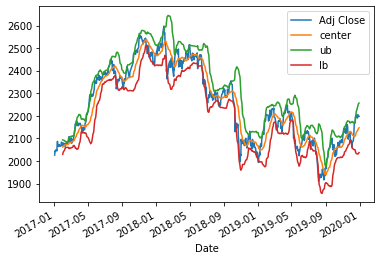

In [13]:
sample[['Adj Close',	'center',	'ub',	'lb']].plot()

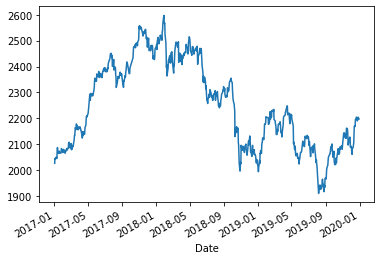

In [14]:
df['Adj Close'].plot() #수정종가

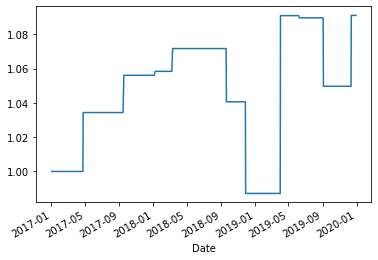

In [15]:
book['acc return'].plot() #누적수익률

In [16]:
#5년

In [17]:
df = yf.download('^KS11', start = '2015-01-01', end='2019-12-31')
#^KS11 : KOSPI Composite Index (코스피 지수)
#^KQ11 : KOSDAQ Composite Index (코스닥 지수)
#KOSPI 200 Index (^KS200)

[*********************100%***********************]  1 of 1 completed


In [18]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,1914.239990,1929.150024,1909.670044,1926.439941,1926.439941,258800
2015-01-05,1921.959961,1921.959961,1903.369995,1915.750000,1915.750000,313400
2015-01-06,1895.479980,1900.020020,1877.380005,1882.449951,1882.449951,303700
2015-01-07,1878.900024,1887.599976,1876.270020,1883.829956,1883.829956,280500
2015-01-08,1895.849976,1907.229980,1891.770020,1904.650024,1904.650024,262200


In [19]:
df['CODE'] = 'SPY'
price_df = df.loc[:,['Adj Close']].copy()
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선
  # +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 
  # -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

n = 20 #이평선
sigma = 2 #시그마

def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선 
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

bollinger = bollinger_band(price_df, n, sigma)

base_date = '2009-01-02'

sample = bollinger.loc[base_date:]
book = sample[['Adj Close']].copy()
book['trade'] = '' #거래내역 컬럼

def create_trade_book(sample):
  book = sample[['Adj Close']].copy()
  book['trade'] = ''
  return (book)   

book = create_trade_book(sample)

def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
               book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

book = tradings(sample,book)

for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
           buy = book.loc[i, 'Adj Close']
           print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

print(returns(book))    

진입일 :  2015-06-03 00:00:00 long 진입가격 :  2063.159912109375
청산일 :  2015-10-08 00:00:00 long 진입가격 :  2063.159912109375  |  long 청산가격 :  2019.530029296875  | return: 0.9789
진입일 :  2015-11-10 00:00:00 long 진입가격 :  1996.5899658203125
청산일 :  2016-04-14 00:00:00 long 진입가격 :  1996.5899658203125  |  long 청산가격 :  2015.9300537109375  | return: 1.0097
진입일 :  2016-06-24 00:00:00 long 진입가격 :  1925.239990234375
청산일 :  2016-08-09 00:00:00 long 진입가격 :  1925.239990234375  |  long 청산가격 :  2043.780029296875  | return: 1.0616
진입일 :  2016-09-12 00:00:00 long 진입가격 :  1991.47998046875
청산일 :  2016-12-08 00:00:00 long 진입가격 :  1991.47998046875  |  long 청산가격 :  2031.0699462890625  | return: 1.0199
진입일 :  2017-04-11 00:00:00 long 진입가격 :  2123.85009765625
청산일 :  2017-04-25 00:00:00 long 진입가격 :  2123.85009765625  |  long 청산가격 :  2196.85009765625  | return: 1.0344
진입일 :  2017-08-09 00:00:00 long 진입가격 :  2368.389892578125
청산일 :  2017-09-18 00:00:00 long 진입가격 :  2368.389892578125  |  long 청산가격 :  2418.2099609375  | retu

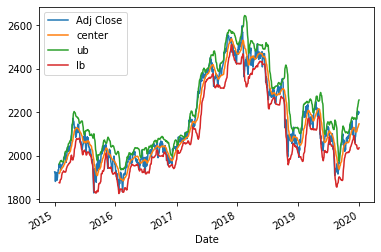

In [20]:
sample[['Adj Close',	'center',	'ub',	'lb']].plot()

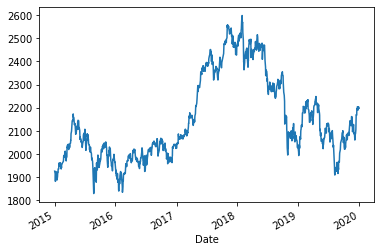

In [21]:
df['Adj Close'].plot() #수정종가

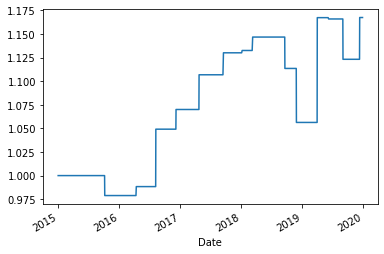

In [22]:
book['acc return'].plot() #누적수익률

In [23]:
#10년

In [24]:
df = yf.download('^KS11', start = '2009-01-01', end='2019-12-31')
#^KS11 : KOSPI Composite Index (코스피 지수)
#^KQ11 : KOSDAQ Composite Index (코스닥 지수)
#KOSPI 200 Index (^KS200)

[*********************100%***********************]  1 of 1 completed


In [25]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,1132.869995,1157.400024,1118.839966,1157.400024,1157.400024,340800
2009-01-05,1180.979980,1185.219971,1166.660034,1173.569946,1173.569946,414800
2009-01-06,1183.520020,1203.589966,1179.939941,1194.280029,1194.280029,444200
2009-01-07,1198.849976,1228.560059,1195.199951,1228.170044,1228.170044,568600
2009-01-08,1212.699951,1218.430054,1195.150024,1205.699951,1205.699951,472300


In [26]:
df['CODE'] = 'SPY'
price_df = df.loc[:,['Adj Close']].copy()
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선
  # +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 
  # -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

n = 20 #이평선
sigma = 2 #시그마

def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선 
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

bollinger = bollinger_band(price_df, n, sigma)

base_date = '2009-01-02'

sample = bollinger.loc[base_date:]
book = sample[['Adj Close']].copy()
book['trade'] = '' #거래내역 컬럼

def create_trade_book(sample):
  book = sample[['Adj Close']].copy()
  book['trade'] = ''
  return (book)   

book = create_trade_book(sample)

def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
               book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

book = tradings(sample,book)

for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
           buy = book.loc[i, 'Adj Close']
           print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

print(returns(book))    

진입일 :  2009-02-20 00:00:00 long 진입가격 :  1065.949951171875
청산일 :  2009-03-17 00:00:00 long 진입가격 :  1065.949951171875  |  long 청산가격 :  1163.8800048828125  | return: 1.0919
진입일 :  2009-10-29 00:00:00 long 진입가격 :  1585.8499755859375
청산일 :  2010-03-08 00:00:00 long 진입가격 :  1585.8499755859375  |  long 청산가격 :  1660.0400390625  | return: 1.0468
진입일 :  2010-05-06 00:00:00 long 진입가격 :  1684.7099609375
청산일 :  2010-09-13 00:00:00 long 진입가격 :  1684.7099609375  |  long 청산가격 :  1818.8599853515625  | return: 1.0796
진입일 :  2011-02-09 00:00:00 long 진입가격 :  2045.5799560546875
청산일 :  2011-03-25 00:00:00 long 진입가격 :  2045.5799560546875  |  long 청산가격 :  2054.0400390625  | return: 1.0041
진입일 :  2011-05-23 00:00:00 long 진입가격 :  2055.7099609375
청산일 :  2011-07-04 00:00:00 long 진입가격 :  2055.7099609375  |  long 청산가격 :  2145.300048828125  | return: 1.0436
진입일 :  2011-08-03 00:00:00 long 진입가격 :  2066.260009765625
청산일 :  2012-01-19 00:00:00 long 진입가격 :  2066.260009765625  |  long 청산가격 :  1914.969970703125  | return:

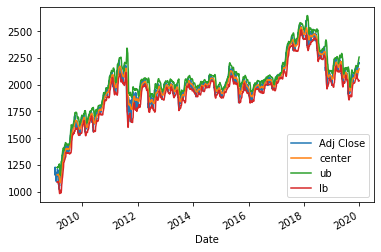

In [27]:
sample[['Adj Close',	'center',	'ub',	'lb']].plot()

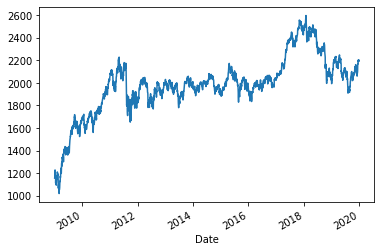

In [28]:
df['Adj Close'].plot() #수정종가

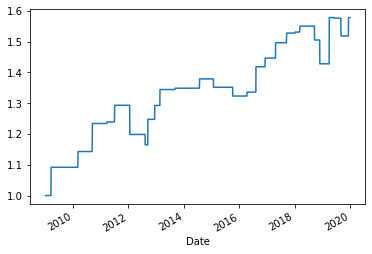

In [29]:
book['acc return'].plot() #누적수익률